In [1]:
from yahoo_fin.stock_info import get_data, get_splits
from datetime import date, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
window_size=20

In [45]:
# set stock ticker symbol
stock_symbol = 'AAPL'
 
# set date range for historical prices
end_time = date.today()
start_time = end_time - timedelta(days=365*10)
 
# reformat date range
end = end_time.strftime('%Y-%m-%d')
start = start_time.strftime('%Y-%m-%d')
 
# get daily stock prices over date range
prices = get_data(stock_symbol, start, end, 'daily')

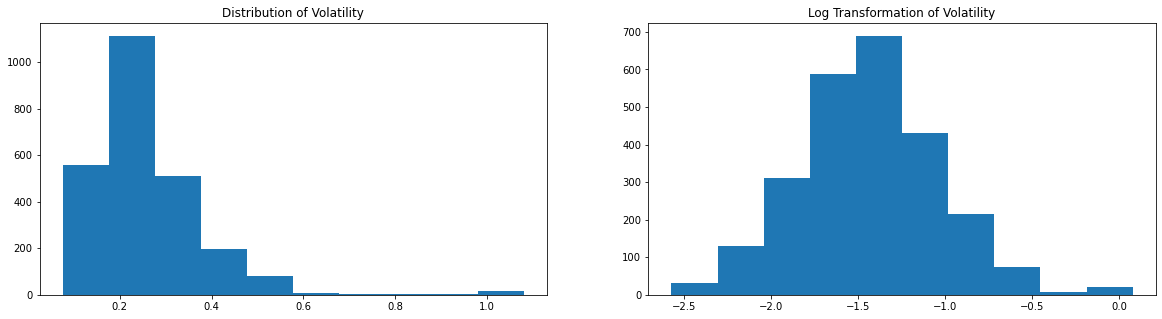

In [46]:
df = prices
#compute daily returns and 20 day moving historical volatility
df['returns']=df['close'].pct_change()
df['volatility']=df['returns'].rolling(window_size).std()*(252**0.5)
df =df.dropna()
df = df.reset_index()
df = df.drop('ticker',axis=1)
X = df['volatility'].values
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(X)
plt.title('Distribution of Volatility')
plt.subplot(122)
plt.hist(np.log(X))
plt.title('Log Transformation of Volatility')
plt.show()

In [47]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
     print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.791258
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [48]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back 
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

x, y = convert2matrix(X,10)
print(x.shape,y.shape)

(2482, 10) (2482,)


In [49]:
from sklearn.model_selection import train_test_split
X,x_valid,y,y_valid = train_test_split(x,y,test_size=0.1,shuffle=False)
X = np.expand_dims(X,2)
x_valid = np.expand_dims(x_valid,2)
print(X.shape,y.shape,x_valid.shape,y_valid.shape)

(2233, 10, 1) (2233,) (249, 10, 1) (249,)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(LSTM(10, input_shape=(X.shape[1],1)))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='mae', optimizer=Adam(0.001))
model.fit(X, y, epochs=10, batch_size=32, validation_data=(x_valid, y_valid), verbose=1, shuffle=False)

Epoch 1/10
70/70 [==============================] - 7s 31ms/step - loss: 0.1400 - val_loss: 0.1330
Epoch 2/10
70/70 [==============================] - 2s 23ms/step - loss: 0.0408 - val_loss: 0.0930
Epoch 3/10
70/70 [==============================] - 1s 11ms/step - loss: 0.0341 - val_loss: 0.0701
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.0305 - val_loss: 0.0641
Epoch 5/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0287 - val_loss: 0.0616
Epoch 6/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0278 - val_loss: 0.0594
Epoch 7/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0269 - val_loss: 0.0568
Epoch 8/10
70/70 [==============================] - 1s 13ms/step - loss: 0.0262 - val_loss: 0.0545
Epoch 9/10
70/70 [==============================] - 1s 12ms/step - loss: 0.0254 - val_loss: 0.0521
Epoch 10/10
70/70 [==============================] - 1s 11ms/step - loss: 0.0246 - val_loss: 0.0496


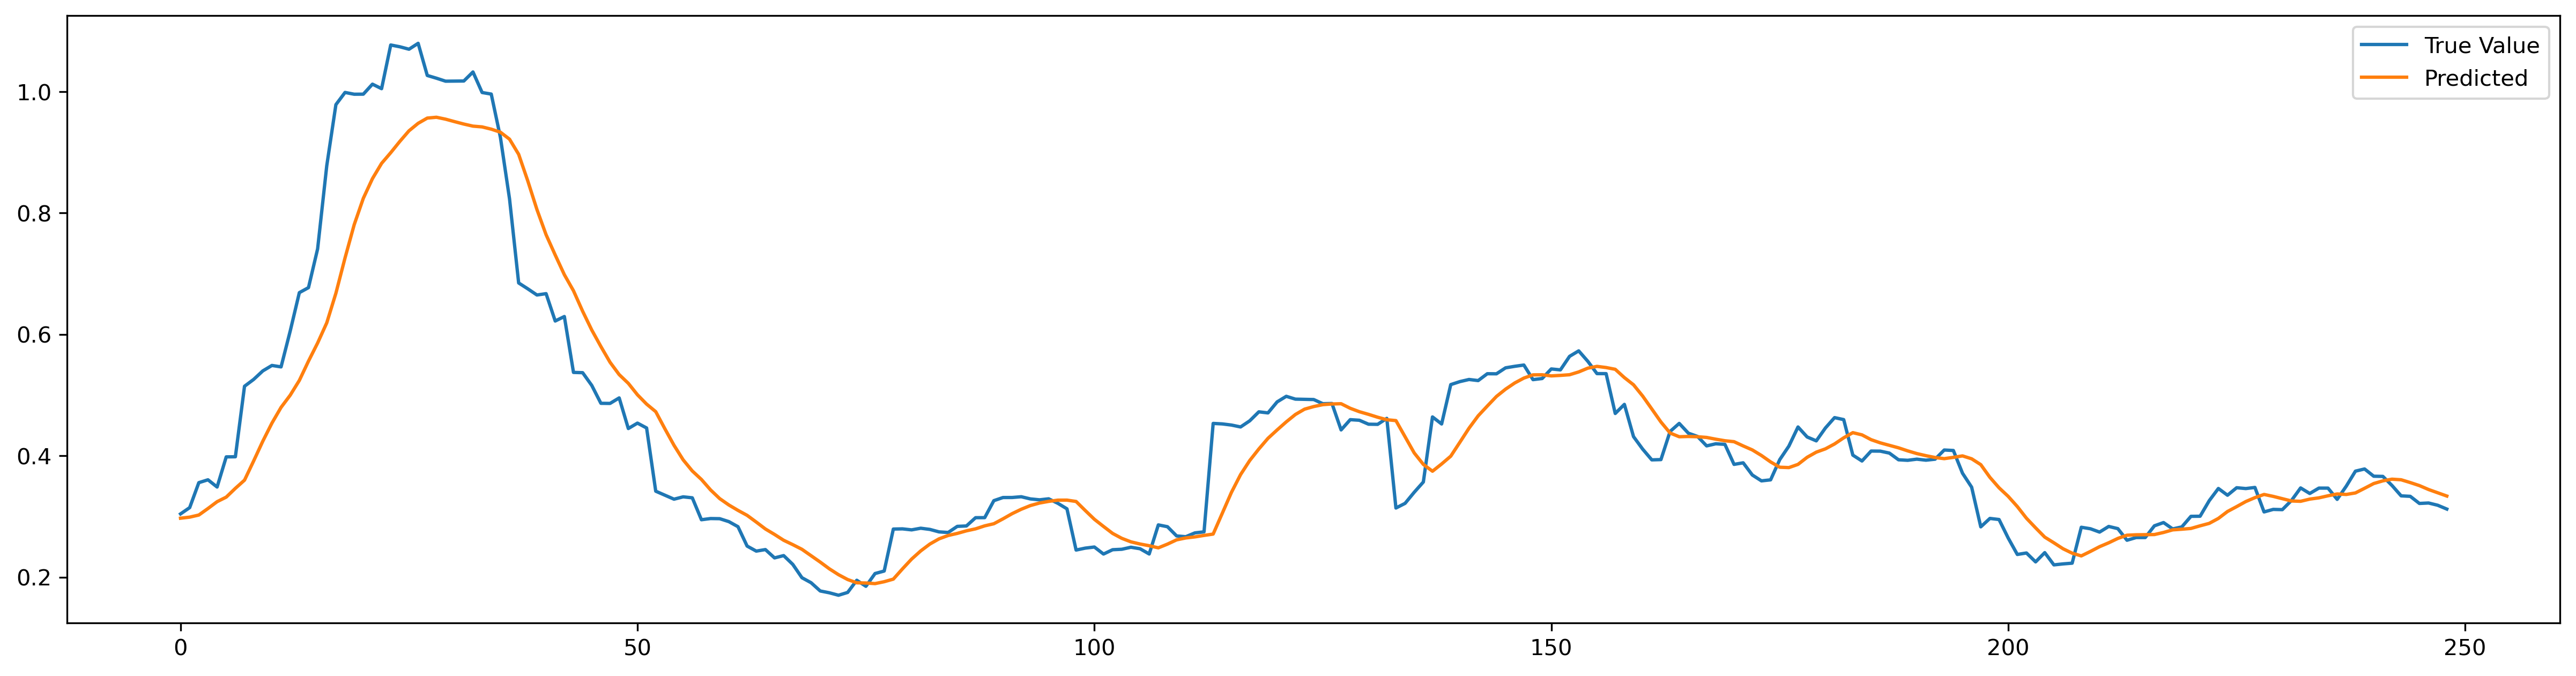

In [52]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(x_valid)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_valid,label='True Value')
plt.plot(pred,linestyle='-', label = 'Predicted')
plt.legend()
plt.show()

In [43]:
x_valid[0]

array([[1.19937704],
       [1.19618392],
       [1.18787676],
       [1.18211833],
       [1.15404883],
       [1.15928157],
       [1.14318192],
       [1.14142459],
       [1.14758373],
       [1.14607535]])

In [53]:
df.tail()

,index,open,high,low,close,adjclose,volume,returns,volatility
2487,2021-02-08,136.029999,136.960007,134.919998,136.910004,136.910004,71297200,0.001097,0.333079
2488,2021-02-09,136.619995,137.880005,135.850006,136.009995,136.009995,76774200,-0.006574,0.321354
2489,2021-02-10,136.479996,136.990005,134.399994,135.389999,135.389999,73046600,-0.004558,0.322104
2490,2021-02-11,135.899994,136.389999,133.770004,135.130005,135.130005,64154400,-0.001920,0.318412
2491,2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300,0.001776,0.312094
